In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [7]:
syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')

In [8]:
#syllable_df= syllable_df[:1000]

In [9]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4..."
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236..."
2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0..."


In [10]:
top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)
top_labels

,en,au,ce,cj,ah,bm,ch,ai,db,aj,ck,hg,ac,ci,fq,ec,df,bx,cr,cl
0,2995,2077,1620,1506,1418,1379,1363,1362,1358,1305,1233,1180,1179,1080,1007,1003,986,984,978,971


In [11]:
syllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

In [12]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4..."
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236..."
12,114.757543,114.986067,bm,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.03662450122476042, -0.022604548403189744, ...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [13]:
syllable_df = syllable_df.reset_index()

In [14]:
syllable_df['subset'] = 'train'
syllable_df.loc[:1000, 'subset'] = 'valid'
syllable_df.loc[1000:1999, 'subset'] = 'test'
#syllable_df.loc[:100, 'subset'] = 'valid'
#syllable_df.loc[100:199, 'subset'] = 'test'

In [15]:
specs = np.array(list(syllable_df.spectrogram.values))
specs = np.array([np.concatenate([np.zeros((32,1)), i], axis=1) for i in tqdm(specs)])
specs.shape

(26984, 32, 32)

In [16]:
syllable_df['spectrogram'] = syllable_df['spectrogram'].astype('object')
syllable_df['spectrogram'] = list(specs)

In [17]:
np.shape(syllable_df['spectrogram'].values[0])

(32, 32)

In [18]:
len(syllable_df)

26984

In [19]:
Y_train = np.array(list(syllable_df.labels.values[syllable_df.subset == 'train']))
Y_valid = np.array(list(syllable_df.labels.values[syllable_df.subset == 'valid']))
Y_test = np.array(list(syllable_df.labels.values[syllable_df.subset == 'test']))

In [20]:
X_train = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'test'])) #/ 255.

In [21]:
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

In [22]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()

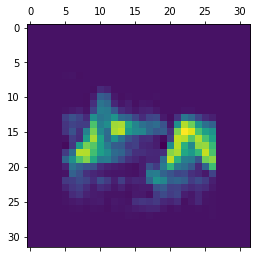

In [23]:
plt.matshow(X_train[10])

In [24]:
X_train[0].shape

(32, 32)

### create models

In [25]:
dims = (32,32,1)

In [26]:
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM
)
n_components=64

In [27]:
#shape_final = (8,2,128)

In [28]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Reshape(target_shape=(8, 2*128)),
    Bidirectional(LSTM(units=100, activation="relu")),
    Dense(units=512),
    Dense(units=n_components),
])

In [29]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    Dense(units=512),
    RepeatVector(8),
    Bidirectional(LSTM(units=100, activation="relu", return_sequences=True)),
    TimeDistributed(Dense(2*128)),
    Reshape(target_shape=(8,2,128)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(1, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(1, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="tanh"
    ),
    Reshape(target_shape=(32, 32, 1)),
])

### Prepare metric

In [30]:
from tfumap.dtw_mse import build_dtw_mse

In [31]:
dtw_metric = build_dtw_mse(X_train[0].shape)

### Create model and train

In [32]:
embedder = tfUMAP(
    metric = dtw_metric,
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    encoder=encoder,
    decoder=decoder,
    decoding_method="network", 
    dims=dims,
    n_components=n_components,
)

In [33]:
z = embedder.fit_transform(X_train_flat)

/mnt/cube/tsainbur/Projects/github_repos/umap/umap/umap_.py:1624: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


tfUMAP(decoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f59f9e40e80>,
       decoding_method='network', dims=(32, 32, 1),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f59fadd87b8>,
       negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f59fae15ba8>,
       tensorboard_logdir='/tmp/tensorboard/20200716-132315',
       training_epochs=5)
Construct fuzzy simplicial set
Thu Jul 16 13:23:18 2020 Finding Nearest Neighbors
Thu Jul 16 13:23:18 2020 Building RP forest with 13 trees
Thu Jul 16 13:23:20 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Thu Jul 16 14:01:09 2020 Finished Nearest Neighbor Search
Thu Jul 16 14:01:13 2020 Embedding with TensorFlow


Thu Jul 16 16:26:02 2020 Finished embedding


In [34]:
z = embedder.transform(X_train_flat)

W0716 16:26:05.160557 140028498937664 base_layer.py:1790] Layer conv2d is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



### Plot model output

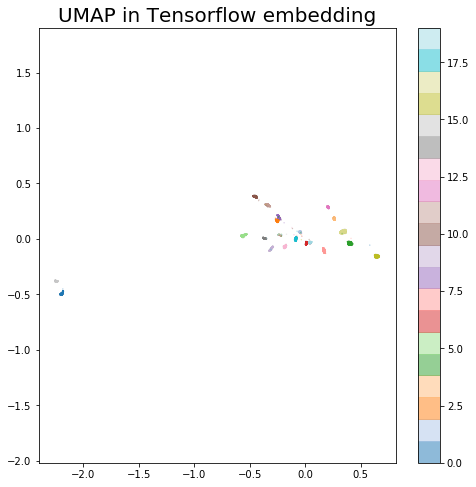

In [35]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train[:len(z)],
    cmap="tab20",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [36]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [37]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'recon_loss']
[]


,wall_time,step,val,group,variable
0,1.594933e+09,1,7.050378,train,umap_loss
1,1.594933e+09,2,6.122189,train,umap_loss
2,1.594933e+09,3,5.345179,train,umap_loss


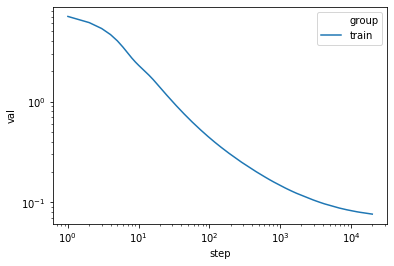

In [38]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')
ax.set_yscale('log')

### Save output

In [39]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [40]:
output_dir = MODEL_DIR/'projections'/ 'cassins' / '64'/ 'recon-network'
ensure_dir(output_dir)

In [41]:
embedder.save(output_dir)

Pickle of model saved


W0716 16:26:23.913370 140028498937664 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0716 16:26:24.293456 140028498937664 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins/64/recon-network/encoder/assets


Encoder Keras model saved


I0716 16:26:27.635433 140028498937664 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins/64/recon-network/decoder/assets


Decoder Keras model saved


In [42]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [43]:
np.save(output_dir / 'z.npy', z)